### Блок 1 Настройка среды и импорт библиотек

In [17]:
!pip install scikit-learn
!pip install numpy pandas matplotlib seaborn scikit-learn ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.1 MB/s eta 0:00:00


In [19]:
#Библиотека
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Выбрали как "дополнительную модель"
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve)
import ipywidgets as widgets
from ipywidgets import interact

### Блок 2 Загрузка данных и первичный анализ (EDA)

In [20]:
# Загрузка датасета
df = pd.read_csv('AI_Impact_on_Jobs_2030.csv')
df.shape

(3000, 18)

In [21]:
# Создаем бинарную классификацию (1 - Высокий риск, 0 - Остальные)
df['Is_High_Risk'] = (df['Risk_Category'] == 'High').astype(int)

In [23]:
#удаляем пропуски если есть
df.dropna()
df.shape

(3000, 19)

In [24]:
# Выбираем признаки (Experience, Exposure Index, Growth Factor)
features = ['Years_Experience', 'AI_Exposure_Index', 'Tech_Growth_Factor']
X = df[features].values

In [25]:
# Целевые переменные
y_reg = df['Average_Salary'].values.reshape(-1, 1)
y_clf = df['Is_High_Risk'].values.reshape(-1, 1)

In [26]:
# Масштабирование (Standartization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Сплит на обучение и тест
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

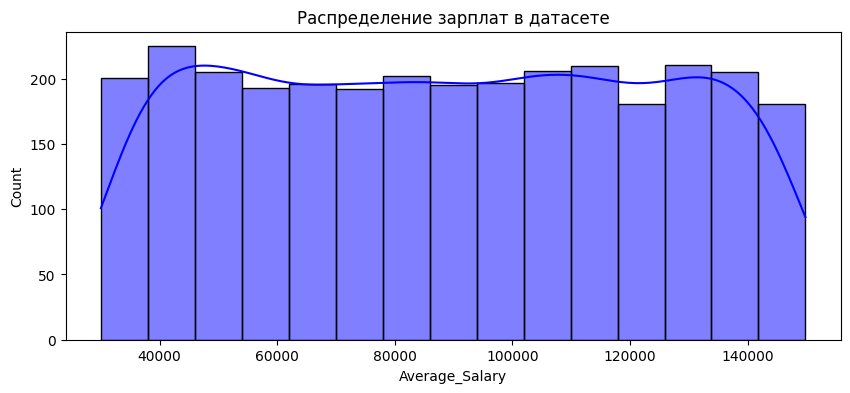

Размер датасета: 3000 строк. Данные готовы к обучению.


In [29]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 4))
sns.histplot(df['Average_Salary'], kde=True, color='blue')
plt.title("Распределение зарплат в датасете")
plt.show()
print(f"Размер датасета: {df.shape[0]} строк. Данные готовы к обучению.")

### Блок 3 Реализация алгоритмов (Numpy Core)

In [31]:
class MyLinearRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr              # Скорость обучения (learning rate)
        self.epochs = epochs      # Количество итераций
        self.weights = None       # Коэффициенты (w)
        self.bias = None          # Свободный член (b)
        self.loss_history = []    # Список для хранения истории ошибки

    def fit(self, X, y):
        # Получаем количество примеров (n_samples) и признаков (n_features)
        n_samples, n_features = X.shape

        # Инициализируем веса нулями
        self.weights = np.zeros((n_features, 1))
        self.bias = 0

        # Основной цикл обучения (Градиентный спуск)
        for i in range(self.epochs):
            # 1. Линейная комбинация: y_pred = X*w + b
            y_pred = np.dot(X, self.weights) + self.bias

            # 2. Расчет функции потерь (MSE - Mean Squared Error)
            loss = np.mean((y_pred - y)**2)
            self.loss_history.append(loss)

            # 3. Вычисление градиентов (производных функции потерь по w и b)
            # Формула: dL/dw = (2/n) * X.T * (y_pred - y)
            dw = (2/n_samples) * np.dot(X.T, (y_pred - y))
            # Формула: dL/db = (2/n) * sum(y_pred - y)
            db = (2/n_samples) * np.sum(y_pred - y)

            # 4. Обновление параметров (шаг в сторону, противоположную градиенту)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        # Метод для получения предсказаний на новых данных
        return np.dot(X, self.weights) + self.bias

In [32]:
class MyLogisticRegression:
    def __init__(self, lr=0.1, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        # Сигмоида: преобразует любое число в диапазон от 0 до 1
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Инициализация весов
        self.weights = np.zeros((n_features, 1))
        self.bias = 0

        for i in range(self.epochs):
            # 1. Вычисляем линейную сумму: z = X*w + b
            z = np.dot(X, self.weights) + self.bias

            # 2. Применяем функцию активации (получаем вероятности)
            y_pred = self.sigmoid(z)

            # 3. Расчет Log-Loss (Binary Cross-Entropy)
            # Добавляем 1e-9 (эпсилон), чтобы избежать log(0)
            loss = -np.mean(y * np.log(y_pred + 1e-9) + (1-y) * np.log(1 - y_pred + 1e-9))
            self.loss_history.append(loss)

            # 4. Вычисление градиентов
            # Для логистической регрессии градиент выглядит так же, как для линейной,
            # но y_pred здесь — это значения после сигмоиды
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # 5. Обновление параметров
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        # Возвращает вероятности принадлежности к классу 1
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X):
        # Возвращает классы (0 или 1) на основе порога 0.5
        probabilities = self.predict_proba(X)
        return (probabilities > 0.5).astype(int)

### Блок 4 Сравнение моделей и графики метрик

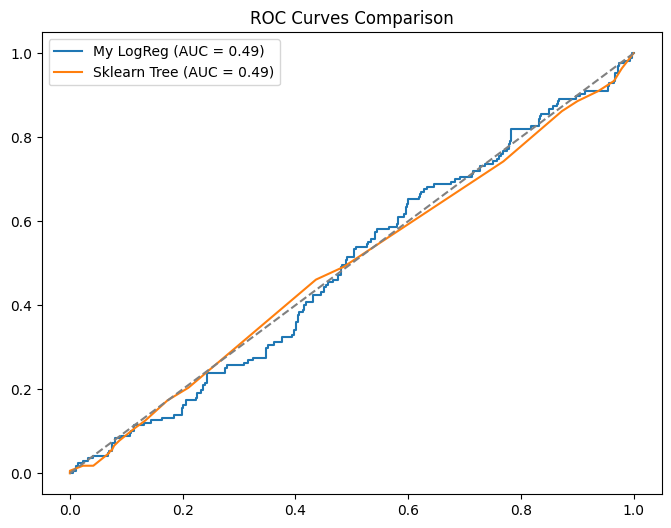

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,My Logistic,Sklearn Tree
0,Accuracy,0.721667,0.710000
1,F1-Score,0.000000,0.033333
2,Precision,0.000000,0.230769


In [33]:
# Обучаем модели
my_log = MyLogisticRegression(lr=0.1, epochs=1000)
my_log.fit(X_train_c, y_train_clf)
y_proba_my = my_log.predict_proba(X_test_c)
y_pred_my = my_log.predict(X_test_c)

sk_tree = DecisionTreeClassifier(max_depth=5).fit(X_train_c, y_train_clf)
y_proba_sk = sk_tree.predict_proba(X_test_c)[:, 1]
y_pred_sk = sk_tree.predict(X_test_c)

# Метрики
fpr1, tpr1, _ = roc_curve(y_test_clf, y_proba_my)
fpr2, tpr2, _ = roc_curve(y_test_clf, y_proba_sk)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'My LogReg (AUC = {roc_auc_score(y_test_clf, y_proba_my):.2f})')
plt.plot(fpr2, tpr2, label=f'Sklearn Tree (AUC = {roc_auc_score(y_test_clf, y_proba_sk):.2f})')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# Таблица метрик
results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'Precision'],
    'My Logistic': [accuracy_score(y_test_clf, y_pred_my), f1_score(y_test_clf, y_pred_my), precision_score(y_test_clf, y_pred_my)],
    'Sklearn Tree': [accuracy_score(y_test_clf, y_pred_sk), f1_score(y_test_clf, y_pred_sk), precision_score(y_test_clf, y_pred_sk)]
})
results.style.background_gradient(cmap='Greens')

### Блок 5 Линейная регрессия и Scatter Plot

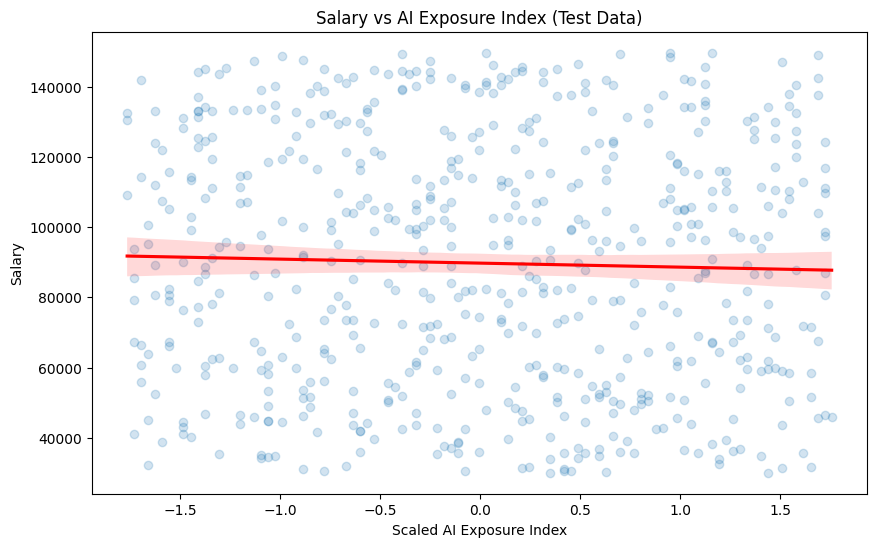

In [34]:
# Модель на одном признаке (AI Exposure Index) для визуализации
lin_reg_vis = MyLinearRegression(lr=0.1, epochs=500)
lin_reg_vis.fit(X_test[:, 1].reshape(-1, 1), y_test_reg)
y_pred_plot = lin_reg_vis.predict(X_test[:, 1].reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.regplot(x=X_test[:, 1], y=y_test_reg.flatten(), scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title("Salary vs AI Exposure Index (Test Data)")
plt.xlabel("Scaled AI Exposure Index")
plt.ylabel("Salary")
plt.show()

### Блок 6 Интерактивный дашборд

In [35]:
@interact
def show_experiments(lr=widgets.FloatSlider(min=0.001, max=0.5, step=0.01, value=0.05, description='Learn Rate'),
                    epochs=widgets.IntSlider(min=100, max=2500, step=100, value=1000, description='Epochs')):

    m1 = MyLinearRegression(lr=lr, epochs=epochs)
    m1.fit(X_train, y_train_reg)

    m2 = MyLogisticRegression(lr=lr, epochs=epochs)
    m2.fit(X_train_c, y_train_clf)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.plot(m1.loss_history); ax1.set_title("Linear Loss (MSE)")
    ax2.plot(m2.loss_history, color='orange'); ax2.set_title("Logistic Loss (LogLoss)")
    plt.show()

    print(f"Final Linear Weights: {m1.weights.flatten().round(3)}")

interactive(children=(FloatSlider(value=0.05, description='Learn Rate', max=0.5, min=0.001, step=0.01), IntSli…